In [1]:
import numpy as np
import pandas as pd
import glob as glob
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import keras
from keras import layers
import tensorflow as tf

2025-04-09 14:12:31.154929: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
agg_files = sorted(glob.glob('/glade/derecho/scratch/dcalhoun/aggregated/tract/Maryland/ifs/0.125/t2m/00/24/*/*/*.csv'))

In [5]:
dfs = []
for f in agg_files:
    df = pd.read_csv(f)
    dfs.append(df)
df = pd.concat(dfs, ignore_index=True)
df.drop(columns=['Unnamed: 0'], inplace=True)
df['time'] = pd.to_datetime(df['time'])
df['dayofyear'] = df['time'].dt.dayofyear

In [6]:
df

,GEOID,time,t2m_abs_error,dayofyear
0,24001000100,2016-01-03,1.337073,3
1,24001000200,2016-01-03,1.441930,3
2,24001000500,2016-01-03,1.464916,3
3,24001000600,2016-01-03,1.464916,3
4,24001000700,2016-01-03,1.464916,3
...,...,...,...,...
4637705,24510280402,2024-11-30,0.130792,335
4637706,24510280403,2024-11-30,0.135976,335
4637707,24510280404,2024-11-30,0.134073,335
4637708,24510280500,2024-11-30,0.096344,335


In [7]:
ntime = int(df.shape[0]/1463)

In [8]:
data = np.array(df['t2m_abs_error']).reshape(ntime,1463)

In [9]:
data

array([[1.33707259, 1.44192963, 1.46491583, ..., 0.83482155, 0.97895669,
        0.97895669],
       [1.26829318, 1.18962222, 1.16692848, ..., 1.01553003, 0.75547959,
        0.75547959],
       [0.82697503, 0.87672818, 0.91484212, ..., 0.90879008, 0.88468913,
        0.88468913],
       ...,
       [1.43946619, 1.76605786, 1.87878517, ..., 1.11235749, 1.25924071,
        1.25924071],
       [0.38384375, 0.38814095, 0.37394804, ..., 0.67043398, 0.61767964,
        0.61767964],
       [0.33849518, 0.38227149, 0.42923709, ..., 0.13407326, 0.09634406,
        0.09634406]])

In [10]:
keras.utils.set_random_seed(812)

In [11]:
# split dataset into training and testing set
X_train, X_test, y_train, y_test = train_test_split(
    data,
    data,
    test_size=0.3,
    shuffle=False,
    random_state=42)

In [13]:
# now rescale your data
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train) # input
X_test = scaler.transform(X_test) # input
y_train = scaler.transform(y_train) # label
y_test = scaler.transform(y_test) # label

In [14]:
# check shapes
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(2219, 1463) (951, 1463) (2219, 1463) (951, 1463)


In [104]:
# create fully connected autoencoder
model = keras.Sequential()

# input
model.add(keras.Input(shape=(1463,))) # features

# encoder
# hidden layers
model.add(layers.Dense(64, activation="relu"))
model.add(layers.Dense(32, activation="relu"))

# desired dimensions
model.add(layers.Dense(4, activation="linear"))

# decoder
model.add(layers.Dense(32, activation="relu"))
model.add(layers.Dense(64, activation="relu"))

# Finally, we add last layer
model.add(layers.Dense(1463, activation='linear')) # back to the original shape

# print model summary
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_24 (Dense)                │ (None, 64)             │        93,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 4)              │           132 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 32)             │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 1463)           │        95,095 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 193,275 (754.98 KB)

 Trainable params: 193,275 (754.98 KB)

 Non-trainable params: 0 (0.00 B)

In [105]:
# define list of metrics
METRICS = [
    keras.metrics.MeanSquaredError(name='mean_squared_error'),
    keras.metrics.RootMeanSquaredError(name='root_mean_squared_error'),
    keras.metrics.MeanAbsoluteError(name='mean_absolute_error'),
]

# compile your nn
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mean_squared_error",
    metrics=METRICS
)

# set hyperparameters
BATCH_SIZE = 32
EPOCHS = 30

In [106]:
# train the NN now
history = model.fit(
    x=X_train,
    y=y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=0.1,
    shuffle=True,
)

Epoch 1/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.6206 - mean_absolute_error: 0.5976 - mean_squared_error: 0.6206 - root_mean_squared_error: 0.7810 - val_loss: 0.2129 - val_mean_absolute_error: 0.3228 - val_mean_squared_error: 0.2129 - val_root_mean_squared_error: 0.4614
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2397 - mean_absolute_error: 0.3431 - mean_squared_error: 0.2397 - root_mean_squared_error: 0.4895 - val_loss: 0.1708 - val_mean_absolute_error: 0.2818 - val_mean_squared_error: 0.1708 - val_root_mean_squared_error: 0.4133
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1919 - mean_absolute_error: 0.2986 - mean_squared_error: 0.1919 - root_mean_squared_error: 0.4380 - val_loss: 0.1528 - val_mean_absolute_error: 0.2631 - val_mean_squared_error: 0.1528 - val_root_mean_squared_error: 0.3909
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1754 - mean_absolute_error: 0.2834 - mean_squared_error: 0.1754 - root_mean_squared_error: 0.4

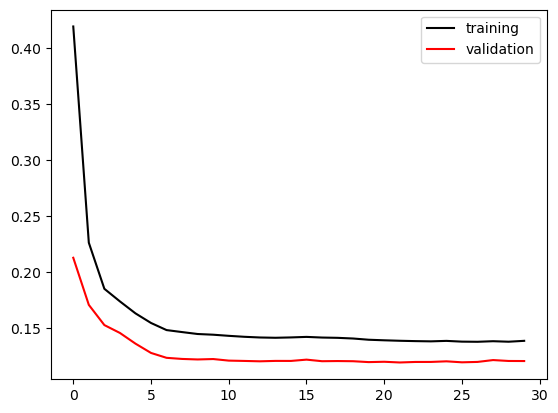

In [107]:
# visualize training and validation curves
plt.plot(history.history["mean_squared_error"], c='k', label='training')
plt.plot(history.history["val_mean_squared_error"], c='r', label='validation')
plt.legend()
plt.show()

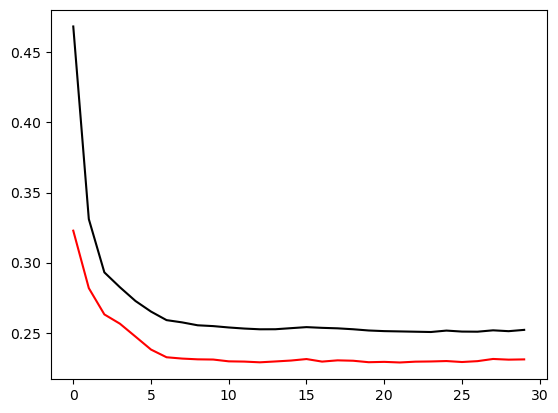

In [108]:
# visualize training and validation curves
plt.plot(history.history["mean_absolute_error"], c='k')
plt.plot(history.history["val_mean_absolute_error"], c='r')
plt.show()

In [109]:
# evaluation mode
y_pred = model.predict(X_test)

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [110]:
# check prediction shape matches test data shape
y_pred.shape

(951, 1463)

In [111]:
y_test.shape

(951, 1463)

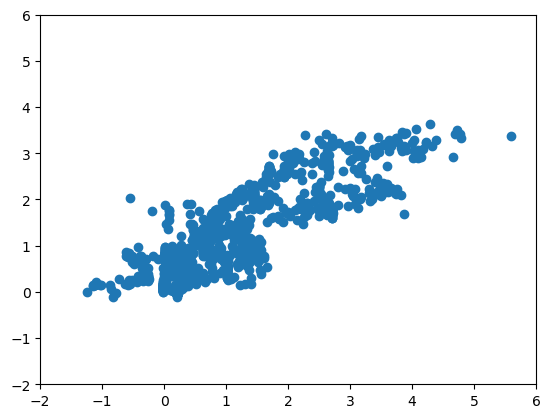

In [112]:
# visualize obs (x-axis) to nn predictions (y-axis)
plt.scatter(y_test[100,:], y_pred[100,:])
plt.xlim([-2,6])
plt.ylim([-2,6])
plt.show()

In [113]:
# we define the input layer to the ANN and the output of the bottleneck layer
bottleneck = tf.keras.Model(
    inputs=model.layers[0].input,
    outputs=model.layers[2].output
    )

In [114]:
# input test data into the bottleneck function
bottleneck_output = bottleneck(X_test)

In [115]:
X_test.shape

(951, 1463)

In [116]:
bottleneck_output.shape

TensorShape([951, 4])

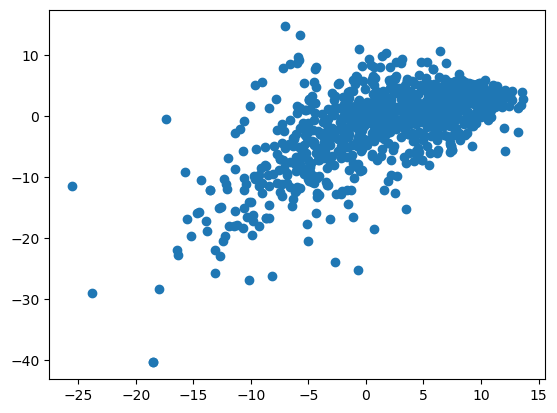

In [117]:
# we can visualize what these two nodes in the bottleneck output
plt.scatter(bottleneck_output[:,0],bottleneck_output[:,1])
plt.show()